# Test atmospheric PSF

In [1]:
from LenSimu.psf.atmospheric import atmosphere
import galsim
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import multiprocessing
from joblib import delayed, Parallel
from time import time
from tqdm import tqdm

### Config

In [3]:
config_path = '/Users/aguinot/Documents/pipeline/LenSimu/config/CFHT/config_psf_cfht.yml'

In [4]:
seed = 1234
rng = np.random.RandomState(seed=seed)
lam = 700
n_psf = 4

In [5]:
pos_sig = 0.3
psf_pos = rng.normal(loc=0, scale=pos_sig, size=(n_psf,2))

### Set an aperture to draw the PSFs

In [6]:
aper = galsim.Aperture(
    diam=3.6, lam=lam, obscuration=0.44,
    nstruts=4, strut_thick=0.05,
    strut_angle=0.*galsim.degrees,
    pad_factor=2.,
    oversampling=2.,
)

## Test single thread

#### Set the atmosphere

In [23]:
atm = atmosphere(config_path, lam*1e-9, seed=seed)

#### PhaseScreen

In [24]:
SL = atm.make_atmosphere()

In [25]:
psf_list = np.zeros(n_psf, dtype=object)
e1_psf = np.ones(n_psf) * -10
e2_psf = np.ones(n_psf) * -10
fwhm_psf = np.ones(n_psf) * -10
mask_psf = np.ones(n_psf, dtype=bool)
ts = time()
for i in tqdm(range(n_psf), total=n_psf):
    psf = SL.makePSF(700, exptime=50, aper=aper, theta=psf_pos[i]*galsim.arcmin)
    psf_img = psf.drawImage(nx=51, ny=51, scale=0.187, method='phot', n_photons=1e6, rng=atm._gal_rng)
    try:
        s = psf_img.FindAdaptiveMom()
        e1_psf[i] = s.observed_shape.e1
        e2_psf[i] = s.observed_shape.e2
        fwhm_psf[i] = s.moments_sigma*2.355*0.187
    except:
        mask_psf[i] = 0
    psf_list[i] = psf_img
print(f'Compute time: {time()-ts}')

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [04:27<00:00,  1.87it/s]

Compute time: 267.31358909606934


Text(0.5, 1.0, 'PSF ellipticities')

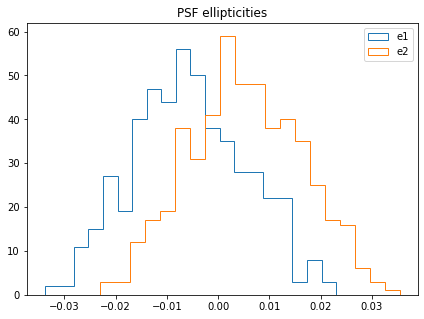

In [26]:
plt.figure(figsize=(7,5))
plt.hist(e1_psf[mask_psf.astype(bool)], 20, histtype='step', label='e1')
plt.hist(e2_psf[mask_psf.astype(bool)], 20, histtype='step', label='e2')
plt.legend()
plt.title('PSF ellipticities')

Text(0.5, 1.0, 'PSF FWHM')

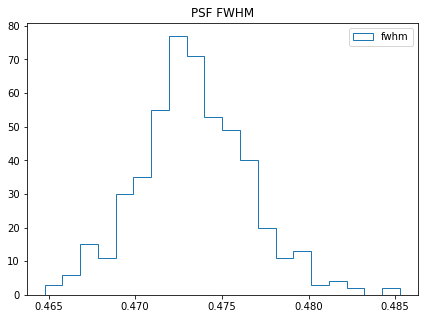

In [27]:
plt.figure(figsize=(7,5))
plt.hist(fwhm_psf[mask_psf.astype(bool)], 20, histtype='step', label='fwhm')
plt.legend()
plt.title('PSF FWHM')

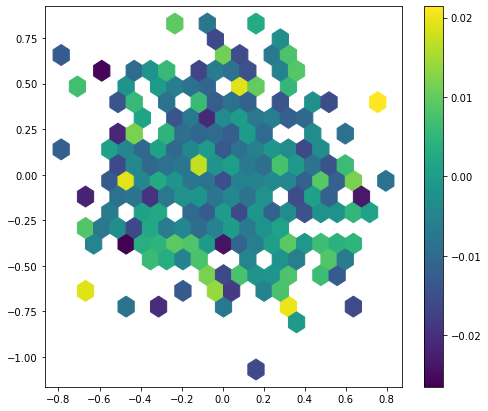

In [34]:
plt.figure(figsize=(8,7))
plt.hexbin(psf_pos[:,0], psf_pos[:,1], e1_psf, gridsize=20)
plt.colorbar()

## Test multi-thread

In [7]:
def runner_func(sl, pos, seed):
    tmp_rng = galsim.BaseDeviate(seed=seed)
    psf = SL.makePSF(700, exptime=50, aper=aper, theta=pos*galsim.arcmin)
    psf_img = psf.drawImage(nx=51, ny=51, scale=0.187, method='phot', n_photons=1e6, rng=tmp_rng)
    try:
        s = psf_img.FindAdaptiveMom()
        e1_psf = s.observed_shape.e1
        e2_psf = s.observed_shape.e2
        fwhm_psf = s.moments_sigma*2.355*0.187
    except:
        e1_psf = -10
        e2_psf = -10
        fwhm_psf = -10
        mask_psf = 0
        
    return e1_psf, e2_psf, fwhm_psf, mask_psf

In [8]:
atm = atmosphere(config_path, lam*1e-9, seed=seed)

In [13]:
ctx = multiprocessing.get_context("spawn")  # "spawn" is generally the safest context available

In [14]:
SL_mp = atm.make_atmosphere(mp_context=ctx)

In [16]:
n_proc = 4
seeds = rng.randint(low=1, high=2**29, size=n_psf)
with ctx.Pool(
    n_proc,
    initializer=galsim.phase_screens.initWorker,
    initargs=galsim.phase_screens.initWorkerArgs()
) as pool:
    results = []
    # First submit
    for i in tqdm(range(n_psf), total=n_psf):
        results.append(pool.apply_async(runner_func, (SL_mp, psf_pos[i], seeds[i])))
    # Then wait to finish
    for r in results:
        r.wait()
# Turn future objects into actual returned images
results = np.array([r.get() for r in results])

100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1024.31it/s]
Process SpawnPoolWorker-12:
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aguinot/miniconda3/envs/lensimu/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/aguinot/miniconda3/envs/lensimu/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aguinot/miniconda3/envs/lensimu/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/aguinot/miniconda3/envs/lensimu/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/aguinot/miniconda3/envs/lensimu/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aguinot/miniconda3/envs/

KeyboardInterrupt: 

In [ ]:
1+1

In [2]:
mp_start_count = 0

if __name__ == '__main__':
    if mp_start_count == 0:
        multiprocessing.set_start_method('fork')
        mp_start_count += 1

In [38]:
seeds = rng.randint(low=1, high=2**29, size=n_psf)
res = Parallel(n_jobs=-1)(
    delayed(runner_func)(SL, psf_pos[i], seeds[i]) for i in tqdm(range(n_psf), total=n_psf)
)

  2%|█▎                                                                               | 8/500 [00:01<01:51,  4.41it/s]

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.